In [38]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [39]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("drive/My Drive")
os.chdir("UCSC COSMOS 2023")
os.chdir("cosmos group project")

!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FileNotFoundError: ignored

In [40]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


In [41]:
#Load Data

EMSLoad2020 = pd.read_excel("./HistoricalEMSHourlyLoad-2020.xlsx")
EMSLoad2021 = pd.read_excel("./HistoricalEMSHourlyLoad-2021.xlsx")
EMSLoad2022 = pd.read_excel("./HistoricalEMSHourlyLoad-2022.xlsx")

WeatherData = pd.read_csv("./sandiego-20200101-20221231.csv")

In [42]:
#Combine EMS Loads
EMSLoads = pd.concat([EMSLoad2020, EMSLoad2021, EMSLoad2022])
EMSLoads.drop(EMSLoads.columns.difference(['Date','HR', 'SDGE']), 1, inplace=True)
EMSLoads = EMSLoads.reset_index(drop=True)

<ipython-input-42-53c9c1e84489>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  EMSLoads.drop(EMSLoads.columns.difference(['Date','HR', 'SDGE']), 1, inplace=True)


In [43]:
timearr  = []

for index, row in EMSLoads.iterrows():
    time = ((row["Date"].to_pydatetime()) + timedelta(hours=(row["HR"]-1)))
    timestring = time.strftime("%Y-%m-%dT%H:%M") #iso8601 without the seconds
    timearr.append(timestring)

EMSLoads["time"] = timearr
EMSLoads.drop(EMSLoads.columns.difference(['time', 'SDGE']), 1, inplace=True)

<ipython-input-43-6dd690bf7e1d>:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  EMSLoads.drop(EMSLoads.columns.difference(['time', 'SDGE']), 1, inplace=True)


In [44]:
CombinedData = pd.merge(
     EMSLoads, WeatherData, on=["time"]
 )

In [45]:
CombinedData['time'] = pd.to_datetime(CombinedData['time'])
CombinedData.set_index("time", inplace = True)

In [46]:
#RUNNING MULTIPLE TIMES ON THE SAME DATAFRAME WILL CAUSE EXTRA VALUES, TO RUN AGAIN RE-RUN
#  THE COMBINED DATA CELL

##This cell block fills up missing/empty rows

prevind = pd.to_datetime("2019-12-31 23:00:00")
CombinedData = CombinedData[~CombinedData.index.duplicated(keep='first')]

for ind in CombinedData.index:
    #print(ind)
    #print(prevind + pd.Timedelta(hours=1))
    nexttime = (prevind + pd.Timedelta(hours=1))
    if(nexttime!=ind):
        print(nexttime)
        CombinedData.loc[nexttime] = [np.NaN] * CombinedData.shape[1]
        #CombinedData.append(pd.Series(name=nexttime))

    prevind = ind

CombinedData = CombinedData.ffill() #fill up values

2020-03-08 02:00:00
2021-03-14 01:00:00
2022-03-13 01:00:00


In [47]:
!pip install "gluonts[torch]"

In [48]:
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch import DeepAREstimator
from gluonts.model.predictor import Predictor
from pathlib import Path


In [49]:
dataset = PandasDataset(CombinedData, target="SDGE", freq="1H")

In [50]:
training_data, test_gen = split(dataset, offset=-5000)
test_data = test_gen.generate_instances(prediction_length=12, windows=3)

In [51]:
model = Predictor.deserialize(Path('./serialized_models/version_10'))


In [52]:


forecasts = list(model.predict(test_data.input))


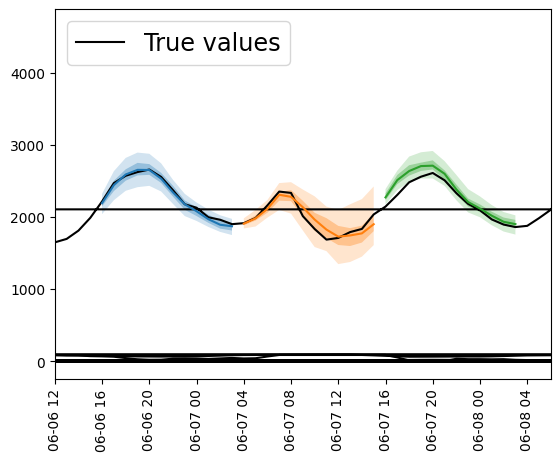

In [53]:

# Plot predictions
plt.plot(CombinedData[:], color="black")

plt.xlim(xmin=pd.to_datetime('2022-06-06 12:00'))
#plt.xlim(xmax=pd.to_datetime('2022-06-10 16:00'))
plt.xlim(xmax=pd.to_datetime('2022-06-08 06:00'))


plt.xticks(rotation=90)


for forecast in forecasts:
  forecast.plot()
plt.legend(["True values"], loc="upper left", fontsize="xx-large")


In [54]:
actualVpredict = pd.DataFrame()

actualListDF = []
predictListDF = []
dateListDF = []
for forecast in forecasts:
    dateList = forecast.index.to_timestamp().tolist()
    medianValues = forecast.quantile(0.5)

    if(len(dateList) != len(medianValues)):
        print("ERROR, DATELIST IS NOT THE SAME LEN AS MEDIANVALUES")

    for i in range(len(dateList)):
        actualListDF.append(CombinedData['SDGE'][pd.to_datetime(dateList[i])])
        predictListDF.append(medianValues[i])
        dateListDF.append(pd.to_datetime(dateList[i]))

actualVpredict["time"] = dateListDF
actualVpredict["prediction"] = predictListDF
actualVpredict["actual"] = actualListDF

actualVpredict.set_index("time", inplace = True)

In [55]:
actualVpredict

,prediction,actual
time,,
2022-06-06 16:00:00,2197.638428,2221.03
2022-06-06 17:00:00,2447.680176,2475.39
2022-06-06 18:00:00,2594.489746,2576.61
2022-06-06 19:00:00,2658.750488,2628.24
2022-06-06 20:00:00,2657.228027,2663.26
2022-06-06 21:00:00,2537.063721,2560.48
2022-06-06 22:00:00,2347.275879,2377.31
2022-06-06 23:00:00,2181.366699,2181.90
2022-06-07 00:00:00,2084.813721,2133.40


import numpy as np
from google.colab import autoviz
df_8006115792618834021 = autoviz.get_df('df_8006115792618834021')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_8006115792618834021, *['prediction'], **{})
chart

import numpy as np
from google.colab import autoviz
df_8006115792618834021 = autoviz.get_df('df_8006115792618834021')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_8006115792618834021, *['actual'], **{})
chart

import numpy as np
from google.colab import autoviz
df_8006115792618834021 = autoviz.get_df('df_8006115792618834021')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_8006115792618834021, *['prediction'], **{})
chart

import numpy as np
from google.colab import autoviz
df_8006115792618834021 = autoviz.get_df('df_8006115792618834021')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_8006115792618834021, *['actual'], **{})
chart

import numpy as np
from google.colab import autoviz
df_8006115792618834021 = autoviz.get_df('df_8006115792618834021')

def scatter_plots(df, colname_pairs, scatter_plot_size=2.5, size=8, alpha=.6):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * scatter_plot_size, scatter_plot_size))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    ax.scatter(df[x_colname], df[y_colname], s=size, alpha=alpha)
    plt.xlabel(x_colname)
    plt.ylabel(y_colname)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(df_8006115792618834021, *[[['prediction', 'actual']]], **{})
chart

In [56]:
actualVpredict.to_csv('actualVpredict.csv', encoding='utf-8')

In [57]:
actualVpredict.shape

(36, 2)